In [1]:
using CSV, DataFrames, FileIO, Images, MLJ, ProgressBars, Flux, IJulia, Random
import MLJFlux
import Optimisers
import MLJIteration # for `skip` control

In [2]:
function classify(ai::Int, real::Int)
    if ai == 1
        return "ai"
    elseif real == 1
        return "real"
    else
        return "unknown"  # You can also filter these out
    end
end

function load_image_safe(path)
    try
        return Images.load(path)
    catch e
        @warn "Could not load $path" exception=e
        return missing
    end
end

function make_input(path)
    
    training_path = path * "_classes.csv"
    labels_df = CSV.read(training_path, DataFrame)
   
    labels_df.label = classify.(labels_df.ai_generated, labels_df.real)
   
    labels_df.image_path = path .* labels_df.filename
    
    labels_df.image = [load_image_safe(paths) for paths in labels_df.image_path]
    filter!(row -> row.image !== missing, labels_df);
   
    # Coerce label into categorical
    labels_df.label = coerce(labels_df.label, Multiclass)

    # Features and Target
    x = labels_df.image
    y = labels_df.label;
   
    return x,y
end

make_input (generic function with 1 method)

In [3]:
X, y = make_input("Ai-Image-Dataset/train/")

(Matrix{RGB{N0f8}}[[RGB(0.31, 0.251, 0.169) RGB(0.306, 0.247, 0.165) … RGB(0.298, 0.243, 0.141) RGB(0.302, 0.247, 0.145); RGB(0.267, 0.208, 0.125) RGB(0.302, 0.243, 0.161) … RGB(0.298, 0.243, 0.141) RGB(0.298, 0.243, 0.141); … ; RGB(0.169, 0.196, 0.133) RGB(0.169, 0.196, 0.133) … RGB(0.196, 0.298, 0.976) RGB(0.176, 0.314, 0.965); RGB(0.18, 0.208, 0.145) RGB(0.18, 0.208, 0.145) … RGB(0.176, 0.314, 0.965) RGB(0.149, 0.329, 0.949)], [RGB(0.165, 0.18, 0.09) RGB(0.165, 0.18, 0.09) … RGB(0.192, 0.212, 0.094) RGB(0.192, 0.212, 0.094); RGB(0.165, 0.18, 0.09) RGB(0.165, 0.18, 0.09) … RGB(0.192, 0.212, 0.094) RGB(0.192, 0.212, 0.094); … ; RGB(0.008, 0.008, 0.008) RGB(0.008, 0.008, 0.008) … RGB(0.051, 0.059, 0.039) RGB(0.051, 0.059, 0.039); RGB(0.008, 0.008, 0.008) RGB(0.008, 0.008, 0.008) … RGB(0.051, 0.059, 0.039) RGB(0.051, 0.059, 0.039)], [RGB(0.149, 0.259, 0.443) RGB(0.157, 0.267, 0.451) … RGB(0.027, 0.027, 0.027) RGB(0.027, 0.027, 0.027); RGB(0.153, 0.263, 0.447) RGB(0.157, 0.267, 0.451) … 

In [4]:
import MLJFlux

struct MyConvBuilder
    filter_size::Int
    channels1::Int
    channels2::Int
    channels3::Int
end

make2d(x::AbstractArray) = reshape(x, :, size(x)[end])

function MLJFlux.build(b::MyConvBuilder, rng, n_in, n_out, n_channels)
    k, c1, c2, c3 = b.filter_size, b.channels1, b.channels2, b.channels3
    mod(k, 2) == 1 || error("`filter_size` must be odd. ")
    p = div(k - 1, 2) # padding to preserve image size
    init = Flux.glorot_uniform(rng)
    front = Chain(
        Conv((k, k), n_channels => c1, pad=(p, p), relu, init=init),
        MaxPool((2, 2)),
        Conv((k, k), c1 => c2, pad=(p, p), relu, init=init),
        MaxPool((2, 2)),
        Conv((k, k), c2 => c3, pad=(p, p), relu, init=init),
        MaxPool((2 ,2)),
        make2d)
    d = Flux.outputsize(front, (n_in..., n_channels, 1)) |> first
    return Chain(front, Dense(d, n_out, init=init))
end

In [5]:
using CUDA
using cuDNN
#import oneAPI

In [9]:
ImageClassifier = @load ImageClassifier pkg=MLJFlux
clf = ImageClassifier(builder=MyConvBuilder(3, 16, 32, 32),
                      acceleration=CUDALibs(),
                      batch_size=35,
                      epochs=80,
                      #rng=123
                      )


import MLJFlux ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\carte\.julia\packages\MLJModels\nxeCf\src\loading.jl:159


ImageClassifier(
  builder = MyConvBuilder(3, 16, 32, 32), 
  finaliser = NNlib.softmax, 
  optimiser = Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), 
  loss = Flux.Losses.crossentropy, 
  epochs = 80, 
  batch_size = 35, 
  lambda = 0.0, 
  alpha = 0.0, 
  rng = TaskLocalRNG(), 
  optimiser_changes_trigger_retraining = false, 
  acceleration = CUDALibs{Nothing}(nothing))

In [ ]:
mach = machine(clf, X, y);
fit!(mach, rows=1:size(X)[1], verbosity=10);
report(mach)
Flux.trainable(mach)

In [ ]:
#Saves our pretrained neural network
MLJ.save("ai_3.jls", mach)

In [ ]:
mach = machine(clf, X, y);
fit!(mach, rows=3000:6000, verbosity=2);
report(mach)
Flux.trainable(mach)
#MLJ.save("ai_3.jls", mach)

┌ Info: Training machine(ImageClassifier(builder = MyConvBuilder(3, 16, 32, 32), …), …).
└ @ MLJBase C:\Users\carte\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Loss is 0.667
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151
┌ Info: Loss is 0.3862
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151
┌ Info: Loss is 0.199
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151
┌ Info: Loss is 0.1203
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151
┌ Info: Loss is 0.09139
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151


In [5]:
#Saves our pretrained neural network
#MLJ.save("ai_neural_network.jls", mach)

#Loads our saved neural network
mach = machine("ai_2.jls")

trained Machine; caches model-specific representations of data
  model: ImageClassifier(builder = MyConvBuilder(3, 16, 32, 32), …)
  args: 


In [6]:

xNew, yNew = make_input("Ai-Image-Dataset/test/")

(Matrix{RGB{N0f8}}[[RGB(0.765, 0.773, 0.678) RGB(0.769, 0.776, 0.682) … RGB(0.322, 0.208, 0.184) RGB(0.318, 0.204, 0.18); RGB(0.761, 0.769, 0.675) RGB(0.765, 0.773, 0.678) … RGB(0.322, 0.208, 0.184) RGB(0.322, 0.208, 0.184); … ; RGB(0.984, 0.976, 0.925) RGB(0.984, 0.976, 0.925) … RGB(0.404, 0.431, 0.369) RGB(0.38, 0.408, 0.345); RGB(0.969, 0.961, 0.91) RGB(0.969, 0.961, 0.91) … RGB(0.416, 0.443, 0.38) RGB(0.396, 0.424, 0.361)], [RGB(0.631, 0.655, 0.639) RGB(0.627, 0.651, 0.635) … RGB(0.627, 0.667, 0.635) RGB(0.627, 0.667, 0.635); RGB(0.639, 0.663, 0.647) RGB(0.635, 0.659, 0.643) … RGB(0.631, 0.671, 0.639) RGB(0.631, 0.671, 0.639); … ; RGB(0.765, 0.792, 0.765) RGB(0.765, 0.792, 0.765) … RGB(0.231, 0.282, 0.976) RGB(0.208, 0.294, 0.969); RGB(0.765, 0.792, 0.765) RGB(0.765, 0.792, 0.765) … RGB(0.208, 0.286, 1.0) RGB(0.18, 0.302, 0.992)], [RGB(0.027, 0.082, 0.275) RGB(0.027, 0.082, 0.275) … RGB(0.094, 0.075, 0.059) RGB(0.098, 0.078, 0.063); RGB(0.027, 0.082, 0.275) RGB(0.027, 0.082, 0.275)

In [7]:

yhat = predict(mach,xNew)

1452-element CategoricalDistributions.UnivariateFiniteVector{Multiclass{2}, String, UInt32, Float32}:
 UnivariateFinite{Multiclass{2}}(ai=>0.000923, real=>0.999)
 UnivariateFinite{Multiclass{2}}(ai=>1.0, real=>1.02e-9)
 UnivariateFinite{Multiclass{2}}(ai=>1.0, real=>5.73e-15)
 UnivariateFinite{Multiclass{2}}(ai=>6.19e-15, real=>1.0)
 UnivariateFinite{Multiclass{2}}(ai=>1.0, real=>4.1e-23)
 UnivariateFinite{Multiclass{2}}(ai=>1.0, real=>5.8e-24)
 UnivariateFinite{Multiclass{2}}(ai=>9.54e-14, real=>1.0)
 UnivariateFinite{Multiclass{2}}(ai=>1.0, real=>0.0)
 UnivariateFinite{Multiclass{2}}(ai=>3.29e-14, real=>1.0)
 UnivariateFinite{Multiclass{2}}(ai=>2.9499999e-28, real=>1.0)
 ⋮
 UnivariateFinite{Multiclass{2}}(ai=>0.986, real=>0.0145)
 UnivariateFinite{Multiclass{2}}(ai=>2.2000001e-21, real=>1.0)
 UnivariateFinite{Multiclass{2}}(ai=>3.18e-11, real=>1.0)
 UnivariateFinite{Multiclass{2}}(ai=>0.000179, real=>1.0)
 UnivariateFinite{Multiclass{2}}(ai=>1.0, real=>1.26e-16)
 UnivariateFinite{Mul

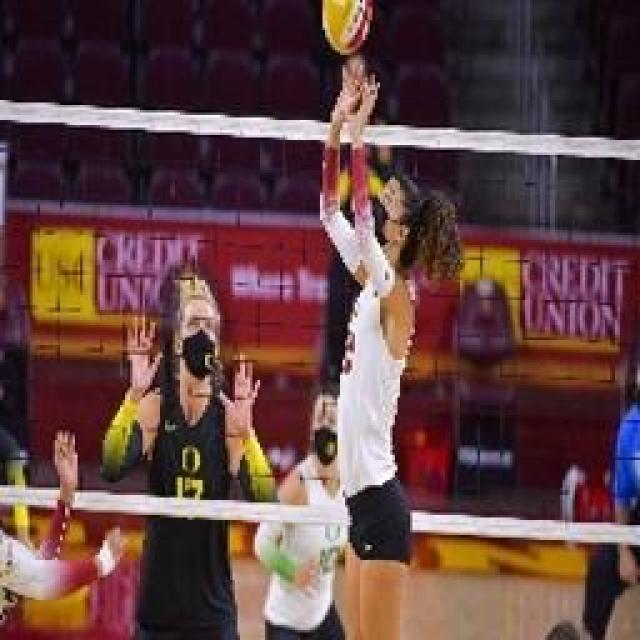

UnivariateFinite{Multiclass{2}}(ai=>8.61e-35, real=>1.0)
real
cUnivariateFinite{Multiclass{2}}(ai=>9.03e-7, real=>1.0)
real
cUnivariateFinite{Multiclass{2}}(ai=>0.4, real=>0.6)


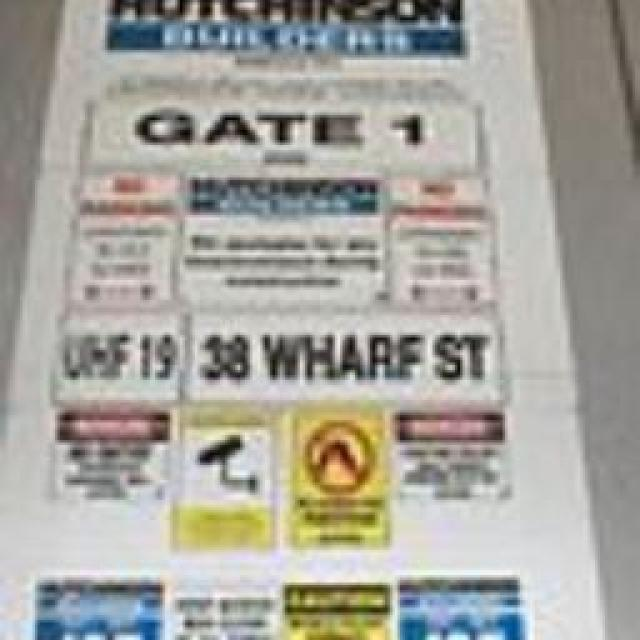

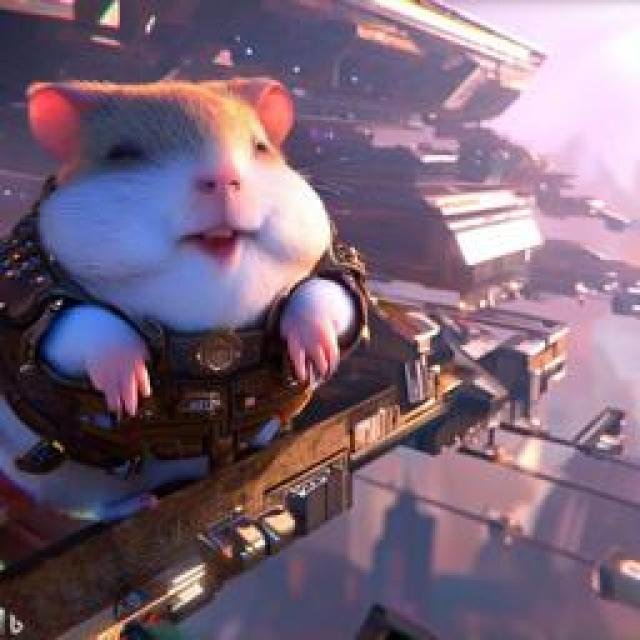

In [ ]:

select = rand(1:size(xNew)[1])
IJulia.display(xNew[select])
sleep(5)
println(yhat[select])
sleep(2)
println(yNew[select])
sleep(3)
print("\033c")

    

In [1]:
img = Images.load("ai.jpg")
img_vec = [img]

UndefVarError: UndefVarError: `Images` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [85]:
result = predict(mach,img_vec)



1-element CategoricalDistributions.UnivariateFiniteVector{Multiclass{2}, String, UInt32, Float32}:
 UnivariateFinite{Multiclass{2}}(ai=>0.998, real=>0.00181)

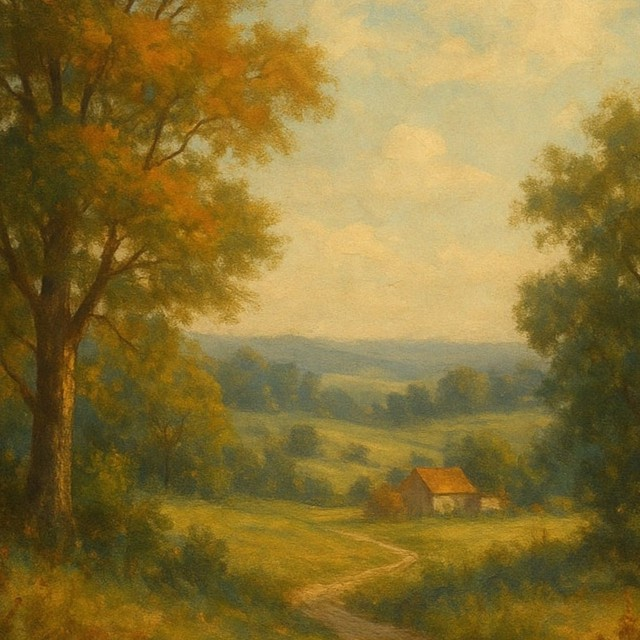

UnivariateFinite{Multiclass{2}, String, UInt32, Float32}[UnivariateFinite{Multiclass{2}}(ai=>0.998, real=>0.00181)]
ai


In [87]:
IJulia.display(img)

println(result)
println("ai")
